# Cell 01 — Environment, Paths, and Reproducibility

**What this cell does (step-by-step)**  
- Imports system, math, random number, and ML libraries; suppresses non-critical warnings.  
- Detects whether the notebook runs in Google Colab; if so, mounts Drive for dataset access.  
- Creates project directory structure (`project/`, `data/`, `checkpoints/`, `logs/`).  
- Sets a global random seed across Python, NumPy, and PyTorch, and enables deterministic CuDNN (turns off autotuner).  
- Detects and prints the compute device.  
- Defines `FER_CSV_PATH` pointing to `fer2013.csv` from Drive (Colab) or local path.  

**Why this approach**  
- *Determinism first*: Fixing seeds and disabling `cudnn.benchmark` ensures reproducibility.  
- *Early I/O fail-fast*: Mounting/reporting paths upfront prevents runtime surprises.  
- *Explicit project scaffold*: Standard locations simplify checkpointing, logging, and automation.  

**Alternatives and trade-offs**  
- `torch.set_float32_matmul_precision('high')` (faster on Ampere+, minor numeric drift).  
- Keep `cudnn.benchmark=True` (faster on fixed shapes, but non-deterministic).  
- Centralize configs via Hydra/pydantic (cleaner experiments, added dependency).  

**How it fits in the overall flow**  
This is the **foundation layer**: reproducible environment + stable file system paths for downstream components.  

---

# Cell 02 — Global Config (Single Source of Truth)

**What this cell does (step-by-step)**  
- Declares `CONFIG` and `HP` dictionaries with data, compute toggles, augmentation, optimizer/scheduler, and hyperparameters.  
- Derives schedule numbers (e.g., taper epochs, fine-tune tail length, augmentation ramp).  
- Defines factories for optimizer and LR schedulers.  
- Prints summary of config and derived values.  

**Why this approach**  
- *Single source of truth*: Prevents config drift and supports auditability.  
- *Derived values once*: Avoids off-by-one errors inside training loop.  
- *Scheduler abstraction*: Clean comparison between policies.  

**Alternatives and trade-offs**  
- Hydra/OmegaConf (more powerful, more boilerplate).  
- K-fold CV config toggle (robust, higher compute).  
- OneCycleLR vs CosineAnnealingLR (faster escape vs stability).  

**How it fits in the overall flow**  
Central config guarantees **consistent behavior** across pipeline, model, and loop.  

---

# Cell 03 — Load FER2013 and Split

**What this cell does (step-by-step)**  
- Validates CSV path, reads into DataFrame, asserts columns.  
- Splits into `train_df`, `val_df`, `test_df` based on official `Usage` column.  
- Prints split counts.  

**Why this approach**  
- *Schema validation*: Catches column mismatches early.  
- *Official splits*: Ensures benchmark comparability.  

**Alternatives and trade-offs**  
- Stratified re-split (flexible, diverges from standard).  
- Extra “dev” split (early stopping fairness, fewer train samples).  

**How it fits in the overall flow**  
Defines the **ground truth partitions** used for training and evaluation.  

---

# Cell 04 — Dataset (48→96), Tensors in [0..255], Shape 1×H×W

**What this cell does (step-by-step)**  
- Implements `FER2013Dataset` to parse pixel strings → `float32` tensors.  
- Validates each image is `48×48`.  
- Resizes to `96×96` with antialiasing.  
- Returns tensors in `[0..255]` with shape `[1,H,W]` and integer labels.  

**Why this approach**  
- *Strict contract*: Normalization/augmentation deferred downstream.  
- *Grayscale preserved*: Sobel stem handles 1→3 conversion explicitly.  
- *Deterministic dataset*: Easier debugging and reproducibility.  

**Alternatives and trade-offs**  
- Store `uint8` (saves memory, requires casting).  
- Resize later in augmentation (flexible, redundant work).  
- Convert to 3-ch grayscale (convenient, risks misuse).  

**How it fits in the overall flow**  
Provides a **clean I/O boundary** for later augmentation/normalization.  

---

# Cell 05 — DataLoaders

**What this cell does (step-by-step)**  
- Builds DataLoaders for train/val/test.  
- Uses `pin_memory` on CUDA, persistent workers, shuffling for train.  
- Prints batch shapes and ranges.  

**Why this approach**  
- *Throughput*: Efficient GPU feeding.  
- *Sanity checks*: Catches shape/range errors early.  

**Alternatives and trade-offs**  
- Tune `prefetch_factor` (faster, higher memory).  
- Deterministic sampling (replicable, less regularization).  

**How it fits in the overall flow**  
Efficient batch streaming into the model, ensuring invariants.  

---

# Cell 06 — Advanced Augmentation Primitives

**What this cell does (step-by-step)**  
- Defines grayscale-safe photometric transforms (noise, gamma, contrast, equalization, JPEG, vignette).  
- Implements geometric (affine, crop, flip) and elastic distortions.  
- Adds safe blur.  
- Provides band occlusion targeting face regions.  
- (Later) includes localized erasing.  

**Why this approach**  
- *Task-aware diversity*: Covers lighting, pose, occlusion.  
- *Range safety*: Prevents numeric drift.  
- *Elastic distortions*: Simulate natural deformations.  

**Alternatives and trade-offs**  
- Albumentations/imgaug (broad, less control).  
- RandAugment/AugMix (standardized, weaker facial priors).  
- Learned policies (optimal, compute-heavy).  

**How it fits in the overall flow**  
Defines the **augmentation vocabulary** for Cell 07.  

---

# Cell 06.x — band_occlusion Utility

**What this cell does (step-by-step)**  
- Occludes regions (eyes/mouth/etc.) with controlled height fractions.  
- Uses neutral fill for brightness consistency.  

**Why this approach**  
- *Domain prior*: Models occlusions common in real faces.  
- *Controlled magnitude*: Preserves overall face integrity.  

**Alternatives and trade-offs**  
- Cutout (simpler, less face-specific).  
- GridMask (uniform, may be too aggressive).  

**How it fits in the overall flow**  
A **specialized occlusion tool** for robustness.  

---

# Cell 07 — AugMix-Lite and Augmentation Builder

**What this cell does (step-by-step)**  
- Builds mixed augmentation policy from primitive banks.  
- Scales probability/magnitude with `strength∈[0,1]`.  
- Normalizes outputs to `[-1,1]`.  

**Why this approach**  
- *Mixture policies*: Broad distortion coverage.  
- *Strength scheduling*: Avoids overwhelming early learning.  
- *Consistent normalization*: Stable model input domain.  

**Alternatives and trade-offs**  
- AutoAugment/RandAugment (standardized, weaker priors).  
- Curriculum augmentation (adaptive, complex).  

**How it fits in the overall flow**  
Creates a **callable transform** for the training loop.  

---

# Cell 08 — Metrics, Class Weights, and Composite Loss

**What this cell does (step-by-step)**  
- Implements accuracy metric.  
- Computes class weights.  
- Defines LS-CE, Focal Loss, and hybrid SmoothedFocal.  

**Why this approach**  
- *Imbalance robustness*: Class weights/focal reduce skew.  
- *Label smoothing*: Improves calibration.  
- *Hybrid*: Balances calibration and hard-example learning.  

**Alternatives and trade-offs**  
- ASL/Balanced Softmax (tailored, more params).  
- Post-hoc calibration (simpler, doesn’t affect training).  

**How it fits in the overall flow**  
Provides the **loss toolkit** for training.  

---

# Cell 09 — MixUp / CutMix and Mixed Criterion

**What this cell does (step-by-step)**  
- Implements MixUp and CutMix with label mixing.  
- Defines `mixed_criterion` for convex loss combination.  

**Why this approach**  
- *Manifold smoothing*: Improves generalization.  
- *Aug regularization*: Complements geometric/photometric aug.  

**Alternatives and trade-offs**  
- FMix (smoother masks, more complexity).  
- No mixing (simpler, less robust).  

**How it fits in the overall flow**  
Plugs into the **per-batch training loop policy**.  

---

# Cell 10 — EMA

**What this cell does (step-by-step)**  
- Tracks EMA “shadow” parameters.  
- Provides update/apply/restore.  

**Why this approach**  
- *Smoother hypothesis*: Improves stability/generalization.  
- *Cheap*: No extra forward compute.  

**Alternatives and trade-offs**  
- SWA (stronger, needs BN recalibration).  
- Snapshot ensembles (accuracy boost, more storage).  

**How it fits in the overall flow**  
A **lightweight ensemble** for evaluation.  

---

# Cell 11 — CBAM and Sobel Stem

**What this cell does (step-by-step)**  
- Implements CBAM attention.  
- Sobel stem: converts 1-ch input into `[x, Gx, Gy]`.  

**Why this approach**  
- *Attention*: Focuses backbone on salient regions.  
- *Sobel*: Edge priors aid expression cues.  

**Alternatives and trade-offs**  
- SE block (lighter, less spatial attention).  
- Learned first conv (standard, no explicit edges).  

**How it fits in the overall flow**  
Enhances the **feature extractor** with priors.  

---

# Cell 12 — Model: EfficientNet-B0 + CBAM + Sobel

**What this cell does (step-by-step)**  
- Loads EfficientNet-B0 backbone.  
- Sobel stem → EfficientNet features.  
- Optional CBAM, then pool → BN → Dropout → Linear(7).  

**Why this approach**  
- *Strong baseline*: EfficientNet-B0 balances accuracy/FLOPs.  
- *Regularized head*: BN+Dropout reduce overfit.  

**Alternatives and trade-offs**  
- ResNet-18/34 (simpler, lower accuracy).  
- Vision Transformers (global context, data-hungry).  
- GroupNorm instead of BN (batch-size independence).  

**How it fits in the overall flow**  
Defines the **core hypothesis class**.  

---

# Cell 13 — Optimizer, Scheduler, Early Stopping

**What this cell does (step-by-step)**  
- Abstracted `make_optimizer` (AdamW/SGD).  
- Warmup+cosine helper.  
- EarlyStopping utility.  

**Why this approach**  
- *Modularity*: Swap optimizers easily.  
- *Guardrails*: Prevents overfitting/wasted epochs.  

**Alternatives and trade-offs**  
- AdamW vs SGD: speed vs generalization.  
- OneCycle (batch-level) vs Cosine/Plateau (epoch-level).  

**How it fits in the overall flow**  
Provides **training stability and flexibility**.  

---

# Cell 14 — Training Loop

**What this cell does (step-by-step)**  
- Builds optimizer/scheduler, early stopper, EMA, AMP scaler.  
- Schedules aug strength, LS, MixUp/CutMix, fine-tune tail.  
- For each batch: normalize → aug → mix → loss → AMP backward → grad clip → step → EMA update.  
- Scheduler step (batch or epoch).  
- Tracks metrics, saves best checkpoint, early stopping.  

**Why this approach**  
- *Curriculum*: Heavy aug early, taper later, clean tail.  
- *Stability stack*: Combines LS, weights, EMA, AMP, clipping.  

**Alternatives and trade-offs**  
- Logit adjustment/Balanced Softmax.  
- Cosine+warmup vs OneCycle.  

**How it fits in the overall flow**  
This is the **learning core**.  

---

# Cell 15 — Build Model and Quick Probe

**What this cell does (step-by-step)**  
- Instantiates model, switches to train.  
- Runs forward/backward on one batch.  
- Prints logits shape and sample loss.  

**Why this approach**  
- *Sanity first*: Catches shape/device/AMP issues early.  

**Alternatives and trade-offs**  
- `torchinfo.summary` (rich, extra dep).  
- Synthetic unit tests (CI-friendly).  

**How it fits in the overall flow**  
A **pre-flight check** before training.  

---

# Aug Utils — localized_erasing

**What this cell does (step-by-step)**  
- Adds random small-patch erasures with mid-gray fills.  
- Integrates into occlusion bank.  

**Why this approach**  
- *Hard negatives*: Mimics occlusion/noise.  

**Alternatives and trade-offs**  
- Cutout/GridMask (simpler, more aggressive).  
- Blur/Noise (softer, less challenging).  

**How it fits in the overall flow**  
Complements the **occlusion augmentations**.  

---

# Cell 16 — Train (Main Run)

**What this cell does (step-by-step)**  
- Calls `fit_with_aug` with loaders + hyperparams.  
- Trains with OneCycle schedule.  
- Saves best checkpoint by `val_loss`.  
- Early stopping if patience exceeded.  

**Why this approach**  
- *Efficient convergence*: OneCycle + EMA.  
- *Resource aware*: Early stopping.  

**Alternatives and trade-offs**  
- Cosine+warmup (simpler, less exploratory).  
- Longer training with stronger regularization.  

**How it fits in the overall flow**  
Executes the **full training procedure**.  

---

# Pre-18 — BN Recalibration

**What this cell does (step-by-step)**  
- Detects BN layers.  
- Builds clean loader (no aug).  
- Updates BN running stats.  
- Reports val/test accuracy post-recal.  

**Why this approach**  
- *BN mismatch fix*: Aligns eval stats.  

**Alternatives and trade-offs**  
- GroupNorm/LayerNorm (batch-size independent).  
- Keep augmented BN (robust eval, less comparable).  

**How it fits in the overall flow**  
Prepares the model for **clean evaluation**.  

---

# Cell 18 — Evaluation (Val/Test + TTA)

**What this cell does (step-by-step)**  
- Defines eval loaders (clean + TTA).  
- Computes accuracies for base, EMA, and optional TTA.  

**Why this approach**  
- *Multiple views*: Base, EMA, TTA cover common eval strategies.  
- *Probability averaging*: Safer than logits averaging.  

**Alternatives and trade-offs**  
- Richer TTA (better, slower).  
- Calibrated thresholds (improves decisions, extra step).  

**How it fits in the overall flow**  
Produces **final metrics**.  

---

# Cell 19 — Confusion Matrix and Per-Class Accuracy

**What this cell does (step-by-step)**  
- Accumulates confusion matrix.  
- Prints per-class accuracies.  
- Uses EMA weights if present.  

**Why this approach**  
- *Error forensics*: Reveals systematic confusions.  
- *Class-wise analysis*: Guides future aug/loss tweaks.  

**Alternatives and trade-offs**  
- Precision/Recall/F1 per class.  
- Calibration metrics.  

**How it fits in the overall flow**  
Supports **diagnostic analysis**.  

---

# Plot Accuracy and Loss Curves

**What this cell does (step-by-step)**  
- Plots training/validation accuracy and loss across epochs.  
- Optionally overlays test accuracy.  

**Why this approach**  
- *Learning dynamics*: Detects over/under-fitting.  
- *Regression detection*: Spots leakage or augmentation bugs.  

**Alternatives and trade-offs**  
- TensorBoard/W&B (interactive, setup required).  
- Rolling averages (smoother, hides spikes).  

**How it fits in the overall flow**  
Provides **visual diagnostics**.  

---

# Cell 20 — Install fvcore

**What this cell does (step-by-step)**  
- Installs `fvcore` for FLOP counting.  

**Why this approach**  
- *Efficiency accounting*: Accuracy/GFLOP matters for deployment.  

**Alternatives and trade-offs**  
- `thop`, `ptflops` (lighter, coverage varies).  
- Torch Dynamo/AOT tracing (modern, complex).  

**How it fits in the overall flow**  
Prepares **tooling** for efficiency profiling.  

---

# Cell 21 — FLOPs + Accuracy/GFLOP

**What this cell does (step-by-step)**  
- Uses `FlopCountAnalysis` to measure FLOPs.  
- Reports GFLOPs and accuracy/GFLOP ratio.  

**Why this approach**  
- *Pareto analysis*: Balances accuracy vs cost.  

**Alternatives and trade-offs**  
- MACs instead of FLOPs.  
- Latency benchmarks (real-world, env-specific).  

**How it fits in the overall flow**  
Provides **computational efficiency metrics**.  

---

# Testing — Accuracy + Image Predictions

**What this cell does (step-by-step)**  
- Rebuilds model, loads checkpoint, computes test accuracy.  
- Prints sample predictions with confidence.  
- Defines helper for arbitrary external images.  

**Why this approach**  
- *Artifact validation*: Confirms saved weights work.  
- *Qualitative check*: Inspects plausibility of errors.  

**Alternatives and trade-offs**  
- Save exact transforms (strict reproducibility).  
- Export to TorchScript/ONNX (deployment portability).  

**How it fits in the overall flow**  
Bridges **trained artifacts** to inference.  

---

# Cell B — Visualization of Predictions

**What this cell does (step-by-step)**  
- Fetches batch, normalizes appropriately.  
- Renders grid with predicted label, confidence, ground truth.  

**Why this approach**  
- *Human-in-the-loop*: Visual debugging of errors.  

**Alternatives and trade-offs**  
- Saliency/Grad-CAM (interpretability, more compute).  
- Misclassification collectors (focused error analysis).  

**How it fits in the overall flow**  
Complements metrics with **qualitative insight**.  

---

# Cell 22 — Save Final Checkpoint & Reload Sanity

**What this cell does (step-by-step)**  
- Saves final checkpoint distinct from “best val”.  
- Reloads, performs a forward pass to confirm.  

**Why this approach**  
- *Traceability*: Retain both final and best artifacts.  
- *Integrity check*: Ensures model reloads cleanly.  

**Alternatives and trade-offs**  
- Save EMA/SWA versions too.  
- Save full training state (resume-friendly, larger).  

**How it fits in the overall flow**  
Delivers **durable artifacts** for sharing or deployment.  

---

# Notes on the Skipped Cell

**Cell 17** — Optional late-phase fine-tune skipped as instructed.  
- Purpose: short clean fine-tune with warmup or SWA to extract final gains after plateau.  

---

# Suggested “How to Read the Notebook” Map

- **Cells 01–03:** Environment and data foundations.  
- **Cells 04–07:** Data interface and augmentation.  
- **Cells 08–13:** Losses, optimizer, and training utilities.  
- **Cell 14:** Training engine.  
- **Cells 15–16:** Sanity probe and main run.  
- **Pre-18 & 18–19:** Clean eval, confusion matrix, class analysis.  
- **Cells 20–21:** Efficiency profiling.  
- **Testing/B/22:** Artifacts, visualization, and final save.  


#Cell 01 — Environment, paths, reproducibility

In [55]:
# === Cell 01: Environment, paths, reproducibility ===
import os, sys, math, random, shutil, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torchvision

warnings.filterwarnings("ignore")

def in_colab() -> bool:
    return "google.colab" in sys.modules

if in_colab():
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
        print("[Env] Google Drive mounted.")
    except Exception as e:
        print(f"[Env][WARN] Drive mount failed: {e}")

# Root dirs (local)
PROJECT_ROOT  = Path("./project"); PROJECT_ROOT.mkdir(parents=True, exist_ok=True)
DATA_ROOT     = Path("./data");    DATA_ROOT.mkdir(parents=True, exist_ok=True)
CKPT_DIR      = PROJECT_ROOT / "checkpoints"; CKPT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR       = PROJECT_ROOT / "logs";        LOG_DIR.mkdir(parents=True, exist_ok=True)

# Seeds
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

# Optional strict determinism (slower but reproducible)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[Env] torch={torch.__version__}, torchvision={torchvision.__version__}, device={device}")

# Data path (edit if needed)
FER_CSV_PATH = Path("/content/drive/MyDrive/fer2013.csv") if in_colab() else Path("./fer2013.csv")
print(f"[Env] CSV path → {FER_CSV_PATH}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Env] Google Drive mounted.
[Env] torch=2.8.0+cu126, torchvision=0.23.0+cu126, device=cuda
[Env] CSV path → /content/drive/MyDrive/fer2013.csv


#Cell 02 — Global config (single source of truth)

| **Category**              | **Setting**                                                                                           |
| ------------------------- | ----------------------------------------------------------------------------------------------------- |
| **Dataset**               | FER2013 (`fer2013.csv`)                                                                               |
| **Image Size**            | 96 × 96                                                                                               |
| **Batch Size**            | 192                                                                                                   |
| **Workers**               | 6 (for DataLoader parallelism)                                                                        |
| **Augmentations**         | Basic (flip, crop, color, etc.)<br>Advanced FER policy (Cell 07)<br>MixUp (α=0.30)<br>CutMix (α=1.00) |
| **Late-Phase Controls**   | Aug cap in final 30%<br>Mix tapering (25% → 90% of epochs)                                            |
| **Label Smoothing**       | Scheduled: 0.10 → 0.02                                                                                |
| **Fine-Tune Tail**        | Last 12% of epochs: no aug/mix, low LR                                                                |
| **Optimizer**             | AdamW (default)<br>Option to switch to SGD+Nesterov (momentum=0.9)                                    |
| **Learning Rate**         | Initial: 3e-4<br>Floor: 5e-5 (cosine/fine-tune)<br>Plateau min: 1e-6                                  |
| **Scheduler**             | ReduceLROnPlateau (factor=0.5, patience=5)<br>Option: CosineAnnealing with warmup=4                   |
| **Weight Decay**          | 5e-5                                                                                                  |
| **Training Epochs**       | 70                                                                                                    |
| **EMA (Exponential MA)**  | Enabled (decay=0.9995)                                                                                |
| **Early Stopping**        | Patience = 18                                                                                         |
| **Test-Time Aug. (TTA)**  | Enabled (only for test set, not validation)                                                           |
| **AMP (Mixed Precision)** | Enabled if CUDA available                                                                             |
| **Checkpointing**         | Saves best model to: `project/checkpoints/best_fer.pth`                                               |


In [56]:
# === Cell 02: Global config (single source of truth, tuned) ===
import os
import torch
from pathlib import Path
from torch.optim import AdamW, SGD
from torch.optim.lr_scheduler import (
    ReduceLROnPlateau, CosineAnnealingLR, LinearLR, SequentialLR, OneCycleLR
)

# Respect upstream paths if defined; otherwise use local defaults
FER_CSV_PATH = FER_CSV_PATH if 'FER_CSV_PATH' in globals() else Path("./fer2013.csv")
CKPT_DIR     = CKPT_DIR     if 'CKPT_DIR'     in globals() else Path("./project/checkpoints")
CKPT_DIR.mkdir(parents=True, exist_ok=True)

def _amp_available() -> bool:
    mps_ok = getattr(torch.backends, "mps", None)
    return bool(torch.cuda.is_available() or (mps_ok and torch.backends.mps.is_available()))

CONFIG = {
    # IO
    "FER_CSV_PATH": FER_CSV_PATH,
    "SAVE_BEST_PATH": CKPT_DIR / "best_fer.pth",

    # Data
    "IMG_SIZE": 96,
    "BATCH_SIZE": 192,
    "NUM_WORKERS": max(2, (os.cpu_count() or 4) - 2),

    # Compute
    "USE_AMP": _amp_available(),

    # Augmentation & evaluation toggles
    "USE_AUG": True,
    "USE_AUG_ADV": True,       # advanced FER policy
    "USE_MIXUP": True,
    "USE_CUTMIX": True,
    "USE_EMA": True,
    "USE_TTA": True,           # val clean; TTA only for test

    # Late-phase controls
    "AUG_CAP_LATE": True,
    "TAPER_MIX_LATE": True,

    # Optimiser and scheduler toggles
    "USE_SGD": False,          # False: AdamW ; True: SGD+Nesterov
    "SCHEDULER": "onecycle",   # 'onecycle' | 'cosine' | 'plateau'

    # Base probabilities for Cell 14’s taper logic
    "BASE_MIXUP_PROB": 0.45,
    "BASE_CUTMIX_PROB": 0.25,

    # Mix prob taper schedule (fractions of total epochs)
    "TAPER_START_FRAC": 0.20,  # start taper a bit earlier
    "TAPER_END_FRAC":   0.85,  # finish taper a bit sooner

    # Label smoothing schedule
    "LABEL_SMOOTH_START": 0.08,  # a touch lower early to recover signal faster
    "LABEL_SMOOTH_END":   0.02,

    # Fine-tuning tail as a fraction of total epochs (no aug/mix, low LR)
    "FINE_TUNE_FRACTION": 0.12,
}

HP = {
    # Core training
    "EPOCHS": 70,
    "LR": 3e-4,        # base LR for AdamW/SGD factories
    "WD": 5e-5,

    # EMA
    "EMA_DECAY": 0.9995,

    # Aug/mix schedule
    # If < 1 it is treated as a FRACTION of total epochs; if >= 1 it is treated as absolute epochs
    "AUG_RAMP_EPOCHS": 0.40,   # longer ramp delays early settling

    "MIXUP_ALPHA": 0.30,
    "CUTMIX_ALPHA": 1.00,

    # Early stopping
    "PATIENCE": 18,

    # LR floors / warmup (cosine path)
    "LR_MIN": 5e-5,            # cosine eta_min
    "WARMUP_EPOCHS": 4,        # cosine warmup only

    # ReduceLROnPlateau (only if SCHEDULER == "plateau")
    "PLATEAU_FACTOR": 0.5,
    "PLATEAU_PATIENCE": 5,
    "MIN_LR": 1e-6,

    # SGD specifics (if you toggle to SGD)
    "SGD_MOMENTUM": 0.9,
    "SGD_NESTEROV": True,

    # One‑Cycle / high‑peak settings (iteration‑level scheduler)
    "LR_MAX": 1.0e-3,          # higher peak to break the ~0.665 plateau
    "OCL_PCT_START": 0.15,     # longer rise phase; smoother early catch‑up
    "OCL_DIV_FACTOR": 12.0,    # initial_lr = LR_MAX / 12  (~8.3e-5) — no tiny LRs
    "OCL_FINAL_DIV": 20.0,     # min_lr ≈ initial_lr / 20
}

# ---- Derived schedule numbers (single source of truth) ----
E = int(HP["EPOCHS"])
assert CONFIG["SCHEDULER"] in ("plateau", "cosine", "onecycle"), \
       "SCHEDULER must be 'plateau', 'cosine', or 'onecycle'"

# Convert AUG_RAMP_EPOCHS to absolute epochs if provided as a fraction
if HP["AUG_RAMP_EPOCHS"] < 1.0:
    HP["AUG_RAMP_EPOCHS"] = max(1, int(round(E * HP["AUG_RAMP_EPOCHS"])))
else:
    HP["AUG_RAMP_EPOCHS"] = int(HP["AUG_RAMP_EPOCHS"])

# Taper windows and fine-tune tail (as absolute epochs)
CONFIG["TAPER_START_EPOCH"] = int(round(CONFIG["TAPER_START_FRAC"] * E))
CONFIG["TAPER_END_EPOCH"]   = max(CONFIG["TAPER_START_EPOCH"] + 1,
                                  int(round(CONFIG["TAPER_END_FRAC"] * E)))
CONFIG["FINE_TUNE_EPOCHS"]  = int(round(CONFIG["FINE_TUNE_FRACTION"] * E))

# Sanity caps
CONFIG["TAPER_START_EPOCH"] = min(CONFIG["TAPER_START_EPOCH"], E - 1)
CONFIG["TAPER_END_EPOCH"]   = min(CONFIG["TAPER_END_EPOCH"],   E)
CONFIG["FINE_TUNE_EPOCHS"]  = min(CONFIG["FINE_TUNE_EPOCHS"],  max(0, E - 1))

# ---- Optimizer factory ----
def make_optimizer(model):
    """Factory: AdamW (default) or SGD+Nesterov."""
    if CONFIG["USE_SGD"]:
        return SGD(model.parameters(),
                   lr=HP["LR"],
                   momentum=HP["SGD_MOMENTUM"],
                   nesterov=HP["SGD_NESTEROV"],
                   weight_decay=HP["WD"])
    else:
        return AdamW(model.parameters(), lr=HP["LR"], weight_decay=HP["WD"])

# ---- Scheduler factories ----
def _make_cosine(optimizer):
    """Linear warmup (no LR change here) then cosine to LR_MIN (epoch-level stepping)."""
    warmup_e = max(0, int(HP["WARMUP_EPOCHS"]))
    warmup = LinearLR(optimizer, start_factor=1.0, end_factor=1.0, total_iters=max(1, warmup_e))
    cosine = CosineAnnealingLR(optimizer, T_max=max(1, E - warmup_e), eta_min=HP["LR_MIN"])
    if warmup_e > 0:
        return SequentialLR(optimizer, schedulers=[warmup, cosine], milestones=[warmup_e])
    return cosine

def _make_plateau(optimizer):
    """ReduceLROnPlateau on val_loss (epoch-level stepping with metric)."""
    return ReduceLROnPlateau(optimizer,
                             mode="min",
                             factor=HP["PLATEAU_FACTOR"],
                             patience=HP["PLATEAU_PATIENCE"],
                             min_lr=HP["MIN_LR"],
                             verbose=True)

def _make_onecycle(optimizer, steps_per_epoch: int):
    """
    OneCycleLR: iteration-level scheduler. Requires steps_per_epoch.
    Ramps LR to LR_MAX quickly, then anneals (cosine).
    """
    return OneCycleLR(
        optimizer,
        max_lr=float(HP["LR_MAX"]),
        epochs=E,
        steps_per_epoch=int(steps_per_epoch),
        pct_start=float(HP["OCL_PCT_START"]),
        anneal_strategy="cos",
        cycle_momentum=False,              # AdamW: momentum cycling unnecessary
        div_factor=float(HP["OCL_DIV_FACTOR"]),
        final_div_factor=float(HP["OCL_FINAL_DIV"])
    )

def build_scheduler(optimizer, steps_per_epoch: int | None = None):
    """
    Unified scheduler builder:
      - onecycle : requires steps_per_epoch (iteration-level stepping)
      - cosine   : epoch-level stepping
      - plateau  : epoch-level stepping, needs val_loss each epoch
    """
    sched = CONFIG["SCHEDULER"]
    if sched == "onecycle":
        if steps_per_epoch is None:
            raise ValueError("OneCycleLR requires steps_per_epoch; pass len(train_dl).")
        return _make_onecycle(optimizer, steps_per_epoch)
    elif sched == "cosine":
        return _make_cosine(optimizer)
    elif sched == "plateau":
        return _make_plateau(optimizer)
    else:
        raise ValueError(f"Unknown scheduler: {sched}")

# ---- Utilities ----
def current_lr(optimizer) -> float:
    """Report the first param group's LR for logging."""
    return float(optimizer.param_groups[0]["lr"])

def scheduler_steps_per_batch() -> bool:
    """True if scheduler.step() should be called every iteration (batch)."""
    return CONFIG["SCHEDULER"] == "onecycle"

def print_config():
    print("\n[CONFIG]")
    for k in sorted(CONFIG.keys()):
        print(f"  {k:20s}: {CONFIG[k]}")
    print("\n[HP]")
    for k in sorted(HP.keys()):
        print(f"  {k:20s}: {HP[k]}")
    print("\n[DERIVED]")
    print(f"  TAPER_START_EPOCH : {CONFIG['TAPER_START_EPOCH']}")
    print(f"  TAPER_END_EPOCH   : {CONFIG['TAPER_END_EPOCH']}")
    print(f"  FINE_TUNE_EPOCHS  : {CONFIG['FINE_TUNE_EPOCHS']}")
    print(f"  AUG_RAMP_EPOCHS   : {HP['AUG_RAMP_EPOCHS']}")

print_config()



[CONFIG]
  AUG_CAP_LATE        : True
  BASE_CUTMIX_PROB    : 0.25
  BASE_MIXUP_PROB     : 0.45
  BATCH_SIZE          : 192
  FER_CSV_PATH        : /content/drive/MyDrive/fer2013.csv
  FINE_TUNE_EPOCHS    : 8
  FINE_TUNE_FRACTION  : 0.12
  IMG_SIZE            : 96
  LABEL_SMOOTH_END    : 0.02
  LABEL_SMOOTH_START  : 0.08
  NUM_WORKERS         : 10
  SAVE_BEST_PATH      : project/checkpoints/best_fer.pth
  SCHEDULER           : onecycle
  TAPER_END_EPOCH     : 60
  TAPER_END_FRAC      : 0.85
  TAPER_MIX_LATE      : True
  TAPER_START_EPOCH   : 14
  TAPER_START_FRAC    : 0.2
  USE_AMP             : True
  USE_AUG             : True
  USE_AUG_ADV         : True
  USE_CUTMIX          : True
  USE_EMA             : True
  USE_MIXUP           : True
  USE_SGD             : False
  USE_TTA             : True

[HP]
  AUG_RAMP_EPOCHS     : 28
  CUTMIX_ALPHA        : 1.0
  EMA_DECAY           : 0.9995
  EPOCHS              : 70
  LR                  : 0.0003
  LR_MAX              : 0.001
  LR_M

#Cell 03 — Load FER2013 and split

| **Step**                | **Explanation**                                                                                                                                          |
| ----------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Import & Path Setup** | Uses `Path` to ensure `FER_CSV_PATH` is correctly resolved from `CONFIG`. Also includes an assertion to stop execution if the file is missing.           |
| **CSV Read**            | Loads the FER2013 dataset via `pd.read_csv(FER_CSV_PATH)`.                                                                                               |
| **Schema Check**        | Ensures dataset has at least `["emotion", "pixels"]` columns, otherwise throws an error.                                                                 |
| **Dataset Splits**      | Splits the dataset into: <br>• **Training**: 28,709 samples <br>• **Validation (PublicTest)**: 3,589 samples <br>• **Test (PrivateTest)**: 3,589 samples |
| **Index Reset**         | Each split has `.reset_index(drop=True)` so that indices are clean and independent across splits.                                                        |
| **Diagnostics**         | Prints the split sizes and confirms counts (`[Split] train=28709, val=3589, test=3589`).                                                                 |


In [57]:
# === Cell 03: Load FER2013 and split ===
from pathlib import Path
FER_CSV_PATH = Path(CONFIG["FER_CSV_PATH"])
assert FER_CSV_PATH.exists(), f"CSV not found: {FER_CSV_PATH}"

df = pd.read_csv(FER_CSV_PATH)
assert {"emotion","pixels"}.issubset(set(df.columns)), f"Bad columns: {df.columns.tolist()}"
print(df["Usage"].value_counts())

train_df = df[df["Usage"]=="Training"].reset_index(drop=True)
val_df   = df[df["Usage"]=="PublicTest"].reset_index(drop=True)
test_df  = df[df["Usage"]=="PrivateTest"].reset_index(drop=True)
print(f"[Split] train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")


Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64
[Split] train=28709, val=3589, test=3589


#Cell 04 — Dataset (48→96), returns tensor in [0..255], 1×H×W

| **Aspect**                | **Design Choice**                                                             | **Rationale / Benefit**                                                                                |
| ------------------------- | ----------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------ |
| **Objective**             | Provide a minimal, deterministic interface from FER2013 CSV to training loop. | Ensures consistent contract across train/val/test, no hidden randomness or preprocessing in dataset.   |
| **Tensor Contract**       | `x ∈ ℝ[1,H,W]` with values in **0–255 float32**, `y ∈ {0,…,6}`                | Stable shape (1 channel, H×W), raw grayscale preserved, labels cleanly passed to loss.                 |
| **Representation**        | `[1, H, W]` (single grayscale channel)                                        | Matches FER’s original format, avoids 3-channel broadcasting bugs.                                     |
| **Pixel Range**           | Raw float32 in **0–255**                                                      | Keeps dataset as “pure I/O,” centralizes normalization later (avoids double-normalization).            |
| **Parsing**               | `np.fromstring(str(px), sep=" ", dtype=np.float32)`                           | Efficient conversion from CSV’s space-separated pixel string to dense vector.                          |
| **Corruption Guard**      | `assert arr.size == 48*48`                                                    | Fails fast if a row is malformed (data corruption check).                                              |
| **Resizing**              | 48×48 → **96×96**, bilinear, `antialias=True`                                 | More spatial detail for features (eyes, mouth) without heavy compute cost. Standardized interpolation. |
| **Tensor Handling**       | `.contiguous()`                                                               | Guarantees compact memory layout for CUDA/augmentations (avoids strided tensor issues).                |
| **Label Handling**        | `int(self.df.iloc[i]["emotion"])` → auto batch collation to `torch.long`      | Compatible with `CrossEntropyLoss`, no extra conversion required.                                      |
| **No Normalization Here** | Dataset does *not* normalize or augment                                       | Prevents double normalization; all stochasticity handled later (augmentor, loop).                      |
| **Pipeline Fit**          | Compatible with Sobel/CBAM/EfficientNet-B0 stack and grayscale augmentor.     | Dataset delivers exactly what later stages expect, no hidden surprises.                                |
| **Determinism**           | Zero random operations                                                        | Makes debugging easier; any stochasticity is controlled explicitly in augmentation stage.              |
| **Efficiency**            | Uses float32 (4× RAM vs uint8)                                                | Simplifies pipeline, avoids repeated casting; memory trade-off acceptable on modern GPUs.              |
| **Known Limits**          | Needs `InterpolationMode` import in fresh kernel; float32 may waste RAM       | Can optimize later (uint8 → float cast in augmentor) if memory constrained.                            |
| **Scalability**           | Changing `IMG_SIZE` propagates safely downstream                              | Later stages adapt to whatever \[1,H,W] dataset produces.                                              |


In [58]:
# === Cell 04: Dataset (48→96), returns [1,H,W] in 0..255 float ===
import torchvision.transforms.functional as VF
from torch.utils.data import Dataset

class FER2013Dataset(Dataset):
    def __init__(self, df: pd.DataFrame, img_size: int = 96):
        self.df = df.reset_index(drop=True)
        self.img_size = int(img_size)
        if len(self.df) > 0:
            _ = self._get_x(0)

    def _get_x(self, i: int) -> torch.Tensor:
        px = self.df.iloc[i]["pixels"]
        arr = np.fromstring(str(px), sep=" ", dtype=np.float32)
        assert arr.size == 48*48, f"Row {i}: expected 2304 pixels, got {arr.size}"
        x = torch.from_numpy(arr.reshape(48, 48)).unsqueeze(0)  # [1,48,48], float32 in 0..255
        x = VF.resize(
            x,
            [self.img_size, self.img_size],
            interpolation=torchvision.transforms.InterpolationMode.BILINEAR,
            antialias=True,
        )
        return x

    def __len__(self): return len(self.df)

    def __getitem__(self, i):
        x = self._get_x(i).contiguous()  # [1,H,W], float32 0..255
        y = int(self.df.iloc[i]["emotion"])
        return x, y

IMG_SIZE = int(CONFIG["IMG_SIZE"])
train_ds = FER2013Dataset(train_df, IMG_SIZE)
val_ds   = FER2013Dataset(val_df,   IMG_SIZE)
test_ds  = FER2013Dataset(test_df,  IMG_SIZE)
print("[Dataset] ready.")


[Dataset] ready.


#Cell 05 — DataLoaders

| **Aspect**             | **Design Choice**             | **Rationale / Benefit**                                                  |
| ---------------------- | ----------------------------- | ------------------------------------------------------------------------ |
| **Batch size**         | `BATCH` from config           | Flexible tuning; balances GPU memory usage and throughput.               |
| **Workers**            | `NUM_WORKERS` from config     | Parallel data loading → faster pipeline.                                 |
| **Pin memory**         | Enabled if CUDA available     | Faster CPU→GPU transfer, avoids page faults.                             |
| **Training loader**    | Shuffle=True, batch=BATCH     | Randomized sampling prevents bias, improves generalization.              |
| **Validation loader**  | Shuffle=False, batch=2×BATCH  | Deterministic eval + speedup with larger batches.                        |
| **Test loader**        | Same as validation            | Ensures reproducible benchmarking, efficient evaluation.                 |
| **Persistent workers** | Kept alive if workers>0       | Reduces overhead of re-spawning processes per epoch.                     |
| **Sanity check**       | Print val batch shape + range | Debug safeguard: verifies `[N,1,96,96]` shape and pixel range `[0,255]`. |


In [59]:
# === Cell 05: DataLoaders ===
from torch.utils.data import DataLoader

BATCH = int(CONFIG["BATCH_SIZE"])
NUM_WORKERS = int(CONFIG["NUM_WORKERS"])
PIN = bool(torch.cuda.is_available())  # safer on CPU-only runs

train_dl = DataLoader(
    train_ds, batch_size=BATCH, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)
val_dl   = DataLoader(
    val_ds,   batch_size=BATCH*2, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)
test_dl  = DataLoader(
    test_ds,  batch_size=BATCH*2, shuffle=False,
    num_workers=NUM_WORKERS, pin_memory=PIN, persistent_workers=(NUM_WORKERS>0)
)

xb, yb = next(iter(val_dl))
print(f"[Check] val batch: {xb.shape}, range [{xb.min():.1f},{xb.max():.1f}]")


[Check] val batch: torch.Size([384, 1, 96, 96]), range [0.0,255.0]


#Cell 06 — Advanced augmentation primitives (photometric, geometric, occlusion, elastic)

In [60]:
# === Cell 06: Advanced augmentation primitives (grayscale) ===
import io
from PIL import Image, ImageOps
import torch.nn.functional as F

def _to_pil_gray(x255: torch.Tensor) -> Image.Image:
    x = x255.clamp(0,255).to(torch.uint8).squeeze(0).cpu().numpy()
    return Image.fromarray(x, mode='L')

def _from_pil_gray(img: Image.Image) -> torch.Tensor:
    return torch.tensor(np.array(img, dtype=np.uint8), dtype=torch.float32).unsqueeze(0)

def _clip(x): return x.clamp(0.0, 255.0)

# photometric
def gauss_noise(x, sigma=0.02): return _clip(x + torch.randn_like(x)*(sigma*255.))
def rand_gamma(x, gmin=0.85, gmax=1.25):
    g = random.uniform(gmin,gmax); x01=(x/255.).clamp(0,1); return (x01**g)*255.
def rand_contrast(x, scale=0.25):
    c = 1.0+random.uniform(-scale,scale); m=x.mean(dim=(1,2),keepdim=True); return _clip((x-m)*c+m)
def rand_equalize(x):
    img=_to_pil_gray(x); img=ImageOps.equalize(img); return _from_pil_gray(img).to(x.dtype).to(x.device)
def rand_jpeg(x, qmin=55, qmax=85):
    img=_to_pil_gray(x); buf=io.BytesIO(); img.save(buf,format='JPEG',quality=random.randint(qmin,qmax))
    buf.seek(0); img2=Image.open(buf).convert('L'); return _from_pil_gray(img2).to(x.dtype).to(x.device)
def rand_vignette(x, strength=0.25):
    _,H,W=x.shape; yy,xx=torch.meshgrid(torch.linspace(-1,1,H,device=x.device),
                                        torch.linspace(-1,1,W,device=x.device),indexing='ij')
    r=torch.sqrt(xx**2+yy**2); mask=1.0-strength*(r/r.max()).clamp(0,1)
    return _clip(x*mask.unsqueeze(0))

# Range-safe blur: convert to [0,1] → blur → back to [0,255]
def rand_blur(x, k=3):
    x01 = (x/255.).clamp(0,1)
    y01 = torchvision.transforms.functional.gaussian_blur(x01, kernel_size=k)
    return (y01 * 255.0).clamp(0,255)

# geometric
def rand_affine_small(x, max_rot=12, max_trans=0.08, max_shear=8.0, max_scale=0.08):
    H,W=x.shape[-2:]
    angle=random.uniform(-max_rot,max_rot)
    trans=[int(random.uniform(-max_trans,max_trans)*W),int(random.uniform(-max_trans,max_trans)*H)]
    scale=1.0+random.uniform(-max_scale,max_scale)
    shear=[random.uniform(-max_shear,max_shear),0.0]
    return torchvision.transforms.functional.affine(x, angle=angle, translate=trans, scale=scale, shear=shear)

def rand_pad_crop(x, pad=3):
    _,H,W=x.shape; xpad=F.pad(x,(pad,pad,pad,pad),mode='reflect'); i=random.randint(0,2*pad); j=random.randint(0,2*pad)
    return xpad[:,i:i+H, j:j+W]

def rand_hflip(x, p=0.5): return torchvision.transforms.functional.hflip(x) if random.random()<p else x

# elastic
def rand_elastic(x, alpha=1.0, sigma=4.0):
    _,H,W=x.shape
    def _gkern(k=21,s=sigma):
        ax=torch.arange(k,device=x.device)-(k-1)/2; ker=torch.exp(-(ax**2)/(2*s*s)); ker/=ker.sum(); return ker
    k=21; gx=_gkern(k).view(1,1,1,k); gy=_gkern(k).view(1,1,k,1)
    dx=F.conv2d(F.conv2d(torch.randn(1,1,H,W,device=x.device),gx,padding=(0,k//2)),gy,padding=(k//2,0)).squeeze()*alpha
    dy=F.conv2d(F.conv2d(torch.randn(1,1,H,W,device=x.device),gx,padding=(0,k//2)),gy,padding=(k//2,0)).squeeze()*alpha
    yy,xx=torch.meshgrid(torch.linspace(-1,1,H,device=x.device),
                         torch.linspace(-1,1,W,device=x.device),indexing='ij')
    xx=(xx+dx/(W/2)).clamp(-1,1); yy=(yy+dy/(H/2)).clamp(-1,1)
    grid=torch.stack([xx,yy],dim=-1).unsqueeze(0)
    return F.grid_sample(x.unsqueeze(0), grid, mode='bilinear', padding_mode='border', align_corners=True).squeeze(0)

# occlusio


In [61]:
# === Cell 06.x: Aug Utils — band_occlusion  ===
import torch
import random

def _neutral_fill_value_range_aware(x: torch.Tensor) -> float:
    """
    Mid-gray fill compatible with [-1,1], [0,1], or [0,255] ranges.
    """
    xmin = float(x.min())
    xmax = float(x.max())
    if xmin >= -1.0 and xmax <= 1.0:
        return 0.0
    if xmin >= 0.0 and xmax <= 1.0:
        return 0.5
    if xmax > 1.0:
        return 127.5
    return 0.0

def band_occlusion(img: torch.Tensor, mode: str = 'eyes', frac: float = 0.18) -> torch.Tensor:
    """
    Draw a horizontal band occlusion corresponding to a face region.
    Args:
        img: [C,H,W] tensor (float). Accepted ranges: [-1,1], [0,1], [0,255].
        mode: 'eyes' | 'mouth' | 'top' | 'bottom' | 'mid'
        frac: vertical band height as fraction of H.
    Returns:
        Tensor with an occluded band (on a clone).
    """
    if not (torch.is_tensor(img) and img.ndim == 3):
        raise TypeError("band_occlusion expects a tensor of shape [C,H,W].")

    C, H, W = img.shape
    band_h = max(1, int(H * float(frac)))
    fill = _neutral_fill_value_range_aware(img)
    out = img.clone()

    # Default anchors (approximate facial landmarks for FER crops)
    if mode == 'eyes':
        top = int(0.30 * H) - band_h // 2
    elif mode == 'mouth':
        top = int(0.72 * H) - band_h // 2
    elif mode == 'mid':
        top = int(0.50 * H) - band_h // 2
    elif mode == 'top':
        top = int(0.10 * H)
    elif mode == 'bottom':
        top = int(0.85 * H) - band_h
    else:
        # Fallback: random vertical placement
        top = random.randint(0, max(0, H - band_h))

    top = max(0, min(top, H - band_h))
    out[:, top:top + band_h, :] = fill
    return out


#Cell 07 — AugMix‑lite and advanced augmentation builder (returns [-1,1])

In [62]:
# === Cell 07: AugMix-lite + advanced augmentation builder (→ [-1,1]) ===
def _apply_bank(x, bank, k=2):
    y=x.clone()
    for _ in range(k):
        y = random.choice(bank)(y)
    return y

def augmix_lite(x, banks, alpha=0.65, branches=2, depth=2):
    mix=x.clone()
    for _ in range(branches):
        y=_apply_bank(x, random.choice(banks), k=depth)
        mix=mix+y
    mix = mix / (branches+1.0)
    return (1-alpha)*x + alpha*mix

def build_advanced_fer_augment(strength: float):
    s=float(max(0.0,min(1.0,strength)))
    # probabilities
    p_photo=0.7*(0.5+0.5*s); p_geom=0.6*(0.5+0.5*s); p_occl=0.40*(0.5+0.5*s)
    p_equal=0.20*s; p_blur=0.15*s
    # magnitudes
    gamma_rng=(0.85-0.15*s, 1.20+0.05*s)
    contrast=0.20+0.10*s
    jpeg_q=(55-int(10*s), 85)
    vignette=0.15+0.20*s
    elastic_a=0.6+0.8*s
    rot=10+5*s; shear=6+4*s; trans=0.06+0.03*s; scale=0.06+0.04*s

    photometric_bank = [
        lambda z: gauss_noise(z, sigma=0.015+0.02*s),
        lambda z: rand_gamma(z, *gamma_rng),
        lambda z: rand_contrast(z, scale=contrast),
        lambda z: rand_jpeg(z, qmin=jpeg_q[0], qmax=jpeg_q[1]),
        lambda z: rand_vignette(z, strength=vignette),
    ]
    geometric_bank = [
        lambda z: rand_affine_small(z, max_rot=rot, max_trans=trans, max_shear=shear, max_scale=scale),
        lambda z: rand_pad_crop(z, pad=3),
        lambda z: rand_hflip(z, p=0.5),
        lambda z: rand_elastic(z, alpha=elastic_a, sigma=4.0),
    ]
    occlusion_bank = [
        lambda z: band_occlusion(z, mode='eyes',  frac=0.16+0.06*s),
        lambda z: band_occlusion(z, mode='mouth', frac=0.16+0.06*s),
        lambda z: band_occlusion(z, mode='top',   frac=0.14+0.06*s),
        lambda z: localized_erasing(z, min_frac=0.01, max_frac=0.05),
    ]
    banks=[photometric_bank, geometric_bank, occlusion_bank]

    def _norm_to_m11(x255):
        x01=(x255/255.).clamp(0,1)
        return (x01 - 0.5) * 2.0

    def _augment(x):
        if random.random() < p_geom:  x = rand_pad_crop(x, pad=3)
        if random.random() < p_blur:  x = rand_blur(x, k=3)
        if random.random() < p_photo: x = random.choice(photometric_bank)(x)
        x = augmix_lite(x, banks=banks, alpha=CONFIG.get("AUG_ALPHA",0.65), branches=2, depth=2)
        if random.random() < p_geom:  x = random.choice(geometric_bank)(x)
        if random.random() < p_occl:  x = random.choice(occlusion_bank)(x)
        if random.random() < p_equal: x = rand_equalize(x)
        return _norm_to_m11(x)

    return _augment

FER_AUG_FACTORY = build_advanced_fer_augment if CONFIG.get("USE_AUG_ADV", False) else build_advanced_fer_augment


#Cell 08 — Metrics, class weights, losses (Label‑Smoothing + Focal composite)

In [63]:
# === Cell 08: Metrics, class weights, composite loss ===
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter

def accuracy(logits, targets): return (logits.argmax(1) == targets).float().mean()

def compute_class_weights(df) -> torch.Tensor:
    counts = Counter(int(e) for e in df["emotion"].tolist())
    total = sum(counts.values())
    w = torch.tensor([total / max(1, counts.get(c,1)) for c in range(7)], dtype=torch.float32)
    return w / w.mean()

CLASS_WEIGHTS = compute_class_weights(train_df)

class LabelSmoothingCE(nn.Module):
    def __init__(self, eps=0.10, reduction='mean'):
        super().__init__(); self.eps=eps; self.reduction=reduction
    def forward(self, logits, targets):
        n = logits.size(-1); logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true = torch.zeros_like(logp).fill_(self.eps/(n-1))
            true.scatter_(1, targets.unsqueeze(1), 1.0 - self.eps)
        loss = -(true * logp).sum(dim=1)
        return loss.mean() if self.reduction=='mean' else loss

class FocalLoss(nn.Module):
    def __init__(self, gamma=1.5, reduction='mean'):
        super().__init__(); self.g=gamma; self.reduction=reduction
    def forward(self, logits, targets):
        ce = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce)
        fl = (1-pt).pow(self.g) * ce
        return fl.mean() if self.reduction=='mean' else fl

class SmoothedFocal(nn.Module):
    def __init__(self, eps=0.10, gamma=1.5, alpha=0.70, weight=None):
        super().__init__(); self.a=alpha; self.w=weight
        self.lsce = LabelSmoothingCE(eps); self.focal = FocalLoss(gamma)
    def forward(self, logits, targets):
        if self.w is not None:
            ce = F.cross_entropy(logits, targets, reduction='none', weight=self.w.to(logits.device))
            pt = torch.exp(-ce); fl = (1-pt).pow(1.5) * ce
            ls = self.lsce(logits, targets)
            return self.a*ls + (1-self.a)*fl.mean()
        return self.a*self.lsce(logits, targets) + (1-self.a)*self.focal(logits, targets)


#Cell 09 — MixUp / CutMix and mixed criterion

In [64]:
# === Cell 09: MixUp / CutMix and mixed criterion ===
def mixup_data(x, y, alpha=0.2):
    if alpha <= 0.0: return x, y, 1.0, None
    lam = np.random.beta(alpha, alpha)
    idx = torch.randperm(x.size(0), device=x.device)
    return lam*x + (1-lam)*x[idx], (y, y[idx]), lam, idx

def cutmix_data(x, y, alpha=1.0, min_lam=0.3, max_lam=0.7):
    if alpha <= 0.0: return x, y, 1.0, None
    lam = float(np.clip(np.random.beta(alpha, alpha), min_lam, max_lam))
    B,C,H,W = x.size(); idx = torch.randperm(B, device=x.device)
    cut_w = int(W * math.sqrt(1 - lam)); cut_h = int(H * math.sqrt(1 - lam))
    cx, cy = np.random.randint(W), np.random.randint(H)
    x1, x2 = np.clip(cx - cut_w//2, 0, W), np.clip(cx + cut_w//2, 0, W)
    y1, y2 = np.clip(cy - cut_h//2, 0, H), np.clip(cy + cut_h//2, 0, H)
    x[:, :, y1:y2, x1:x2] = x[idx, :, y1:y2, x1:x2]
    lam = 1 - ((x2-x1)*(y2-y1) / (W*H + 1e-9))
    return x, (y, y[idx]), lam, idx

def mixed_criterion(criterion, logits, targets_mix, lam):
    if isinstance(targets_mix, tuple):
        y_a, y_b = targets_mix
        return lam * criterion(logits, y_a) + (1-lam) * criterion(logits, y_b)
    return criterion(logits, targets_mix)


#Cell 10 — EMA (exponential moving average)

In [65]:
# === Cell 10: EMA ===
import torch.nn as nn

class EMA:
    def __init__(self, model: nn.Module, decay: float = 0.999):
        self.decay=float(decay); self.shadow={}; self.backup={}
        for n,p in model.named_parameters():
            if p.requires_grad: self.shadow[n]=p.data.clone()
    def update(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.shadow[n]=(1-self.decay)*p.data + self.decay*self.shadow[n]
    def apply_shadow(self, model):
        self.backup={}
        for n,p in model.named_parameters():
            if p.requires_grad:
                self.backup[n]=p.data.clone(); p.data=self.shadow[n].clone()
    def restore(self, model):
        for n,p in model.named_parameters():
            if p.requires_grad:
                p.data=self.backup[n].clone()
        self.backup={}


#Cell 11 — CBAM and Sobel stem

In [66]:
# === Cell 11: CBAM + Sobel stem ===
import torch.nn.functional as F
import torch.nn as nn
import torch

class CBAM(nn.Module):
    def __init__(self, ch, r=8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(ch, max(1,ch//r), 1, bias=True), nn.ReLU(inplace=True),
            nn.Conv2d(max(1,ch//r), ch, 1, bias=True)
        )
        self.spatial = nn.Sequential(nn.Conv2d(2,1,kernel_size=7,padding=3,bias=False), nn.Sigmoid())
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        ca = self.sigmoid(self.mlp(F.adaptive_avg_pool2d(x,1) + F.adaptive_max_pool2d(x,1)))
        x = x * ca
        ms = torch.cat([x.mean(1,keepdim=True), x.max(1,keepdim=True)[0]], dim=1)
        return x * self.spatial(ms)

class SobelLayer(nn.Module):
    def __init__(self):
        super().__init__()
        kx = torch.tensor([[1,0,-1],[2,0,-2],[1,0,-1]], dtype=torch.float32)
        ky = torch.tensor([[1,2,1],[0,0,0],[-1,-2,-1]], dtype=torch.float32)
        w  = torch.stack([kx, ky]).unsqueeze(1)   # (2,1,3,3)
        self.register_buffer('w', w)
    def forward(self, x):                          # x: [B,1,H,W]
        edges = F.conv2d(x, self.w, padding=1)     # [B,2,H,W]
        return torch.cat([x, edges], dim=1)        # [B,3,H,W]


#Cell 12 — Model: EfficientNet‑B0 + CBAM + Sobel

In [67]:
# === Cell 12: HybridEffNet (EfficientNet‑B0 + CBAM + Sobel) ===
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights

CLASSIFIER_DROPOUT = 0.30
USE_CBAM = True

class HybridEffNet(nn.Module):
    def __init__(self, num_classes=7, classifier_dropout=CLASSIFIER_DROPOUT, use_cbam=USE_CBAM):
        super().__init__()
        self.device = device
        base = efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
        self.sobel    = SobelLayer()          # 1→3 ch stem
        self.features = base.features
        self.pool     = nn.AdaptiveAvgPool2d(1)
        self.cbam     = CBAM(1280) if use_cbam else None
        self.bn       = nn.BatchNorm1d(1280)
        self.drop     = nn.Dropout(p=classifier_dropout)
        self.head     = nn.Linear(1280, num_classes)
        self.to(self.device)

    def forward(self, x1):                    # x1 in [-1,1], [B,1,H,W]
        x3 = self.sobel(x1)                   # [B,3,H,W]
        f  = self.features(x3)                # [B,1280,h,w]
        if self.cbam is not None:
            f = self.cbam(f)
        f  = self.pool(f).flatten(1)          # [B,1280]
        f  = self.bn(f)
        f  = self.drop(f)
        return self.head(f)


#Cell 13 — Optimizer, scheduler, early stopping

In [68]:
# === Cell 13: Optimizer + Scheduler + EarlyStopping (updated) ===
import math
import torch

def make_optimizer(params, hp, cfg):
    """
    AdamW (default) or SGD+Nesterov via CONFIG['USE_SGD'] toggle.
    Uses HP['LR'] and HP['WD'].
    """
    if cfg.get("USE_SGD", False):
        return torch.optim.SGD(
            params,
            lr=hp["LR"],
            momentum=hp["SGD_MOMENTUM"],
            nesterov=hp["SGD_NESTEROV"],
            weight_decay=hp["WD"],
        )
    return torch.optim.AdamW(params, lr=hp["LR"], weight_decay=hp["WD"])

# Back‑compat cosine helper (epoch-level stepping)
class WarmupCosine:
    def __init__(self, opt, warmup_epochs, max_epochs, lr_min=1e-6, lr_max=None):
        self.opt = opt
        self.warmup = max(1, int(warmup_epochs))
        self.maxe = int(max_epochs)
        self.t = 0
        if lr_max is None:
            lr_max = max(pg['lr'] for pg in opt.param_groups)
        self.lr_min, self.lr_max = lr_min, lr_max
    def step(self):
        self.t += 1
        if self.t <= self.warmup:
            lr = self.lr_min + (self.lr_max - self.lr_min) * (self.t / self.warmup)
        else:
            tt = (self.t - self.warmup) / max(1, (self.maxe - self.warmup))
            lr = self.lr_min + 0.5 * (self.lr_max - self.lr_min) * (1 + math.cos(math.pi * tt))
        for g in self.opt.param_groups: g['lr'] = lr
        return lr

# NOTE:
# In Cell 02 you already have build_scheduler(...) and helpers like
#   - scheduler_steps_per_batch()
#   - current_lr()
# We simply keep EarlyStopping here and let Cell 14 call build_scheduler.

class EarlyStopping:
    """Early stop on validation loss. Call .step(val_loss) each epoch."""
    def __init__(self, patience=8, min_delta=1e-4):
        self.patience = int(patience)
        self.min_delta = float(min_delta)
        self.best = float('inf')
        self.bad = 0
    def step(self, val_loss: float) -> bool:
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.bad = 0
            return False
        self.bad += 1
        return self.bad >= self.patience


#Cell 14 — Training loop with advanced aug, MixUp/CutMix, EMA, AMP

In [69]:
# === Cell 14: Training loop (Plateau uses val_loss; OneCycle steps per batch) ===
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class LabelSmoothingCE(nn.Module):
    def __init__(self, eps: float = 0.10, reduction: str = 'mean'):
        super().__init__()
        self.eps = float(eps); self.reduction = reduction
    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        n = logits.size(-1)
        logp = F.log_softmax(logits, dim=-1)
        with torch.no_grad():
            true = torch.zeros_like(logp).fill_(self.eps / (n - 1))
            true.scatter_(1, targets.unsqueeze(1), 1.0 - self.eps)
        loss = -(true * logp).sum(dim=1)
        return loss.mean() if self.reduction == 'mean' else loss

def _get_class_weights_fallback(device: torch.device) -> torch.Tensor | None:
    # 1) Allow explicit override via CONFIG
    if "CLASS_WEIGHTS" in CONFIG and CONFIG["CLASS_WEIGHTS"] is not None:
        cw = CONFIG["CLASS_WEIGHTS"]
        if isinstance(cw, torch.Tensor):
            return cw.to(device=device, dtype=torch.float32)
        return torch.tensor(list(cw), dtype=torch.float32, device=device)
    # 2) FER2013 counts fallback
    class_counts = [4957, 547, 5121, 8989, 6077, 4002, 6198]
    total = sum(class_counts); K = len(class_counts)
    weights = [total / (K * c) for c in class_counts]
    return torch.tensor(weights, dtype=torch.float32, device=device)

def fit_with_aug(model: nn.Module, train_dl, val_dl, hp: dict, cfg: dict):
    """
    - Supports 'plateau' (epoch-level, keyed to **val_loss**), 'cosine' (epoch-level),
      and 'onecycle' (batch-level).
    - Tapered MixUp/CutMix, label smoothing schedule, fine-tune tail, EMA, AMP, clipping.
    """
    device = next(model.parameters()).device

    # --- Optimizer & Scheduler ---
    opt = make_optimizer(model.parameters(), hp, cfg)
    steps_per_epoch = len(train_dl)
    sched = build_scheduler(opt, steps_per_epoch=steps_per_epoch)  # from Cell 02
    use_batch_sched = scheduler_steps_per_batch()                  # True for OneCycle

    stopper = EarlyStopping(patience=hp["PATIENCE"], min_delta=1e-4)
    ema = EMA(model, decay=hp["EMA_DECAY"]) if cfg.get("USE_EMA", True) else None
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.get("USE_AMP", torch.cuda.is_available()))
    cls_weights = _get_class_weights_fallback(device)

    E = int(hp["EPOCHS"])
    ramp_epochs  = max(1, int(float(hp.get("AUG_RAMP_EPOCHS", 0.25)) * E))
    t_start = float(cfg.get("TAPER_START_FRAC", 0.25))
    t_end   = float(cfg.get("TAPER_END_FRAC",   0.90))
    base_mix_p = float(cfg.get("BASE_MIXUP_PROB", 0.5))
    base_cut_p = float(cfg.get("BASE_CUTMIX_PROB", 0.5))
    tail_frac = float(cfg.get("FINE_TUNE_FRACTION", 0.12))
    tail_start_epoch = max(1, int((1.0 - tail_frac) * E))

    history = []
    best_val_loss = float("inf")

    for epoch in range(1, E + 1):
        model.train()
        frac = (epoch - 1) / max(1, E - 1)

        # Aug strength schedule
        if cfg.get("USE_AUG", True):
            s = 0.2 + 0.6 * min(1.0, epoch / ramp_epochs)
            if cfg.get("AUG_CAP_LATE", True) and epoch >= int(0.7 * E):
                s = min(s, 0.6)
            augment = FER_AUG_FACTORY(s)
        else:
            augment = None

        # MixUp/CutMix taper
        if frac < t_start:
            p_mix, p_cut = base_mix_p, base_cut_p
        elif frac > t_end:
            p_mix, p_cut = 0.0, 0.0
        else:
            tf = (frac - t_start) / max(1e-8, (t_end - t_start))
            p_mix, p_cut = base_mix_p * (1.0 - tf), base_cut_p * (1.0 - tf)

        # Fine-tune tail
        if epoch >= tail_start_epoch:
            augment = None; p_mix = p_cut = 0.0
            for g in opt.param_groups:
                g['lr'] = max(hp["LR_MIN"], 0.2 * hp["LR"])

        # Label smoothing schedule
        eps0 = float(cfg.get("LABEL_SMOOTH_START", 0.10))
        eps1 = float(cfg.get("LABEL_SMOOTH_END",   0.02))
        eps_now = eps0 + (eps1 - eps0) * frac
        ce_ls = LabelSmoothingCE(eps=eps_now)

        # ---- Train one epoch ----
        seen, loss_sum = 0, 0.0
        for xb, yb in train_dl:
            xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)

            # Normalize/augment
            if augment is not None:
                xb = torch.stack([augment(x) for x in xb])
            else:
                xb = ((xb / 255.0) - 0.5) * 2.0

            # Mix strategies
            do = random.random()
            targets_mix, lam = yb, 1.0
            if cfg.get("USE_MIXUP", True) and do < p_mix:
                xb, targets_mix, lam, _ = mixup_data(xb, yb, alpha=hp["MIXUP_ALPHA"])
            elif cfg.get("USE_CUTMIX", True) and do < (p_mix + p_cut):
                xb, targets_mix, lam, _ = cutmix_data(xb, yb, alpha=hp["CUTMIX_ALPHA"])

            opt.zero_grad(set_to_none=True)
            with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=cfg.get("USE_AMP", False)):
                logits = model(xb)
                if isinstance(targets_mix, tuple):
                    loss_main = lam * ce_ls(logits, targets_mix[0]) + (1.0 - lam) * ce_ls(logits, targets_mix[1])
                else:
                    loss_main = ce_ls(logits, yb)
                if cls_weights is not None:
                    ce_raw = F.cross_entropy(logits, yb, weight=cls_weights, reduction='mean')
                    loss = 0.75 * loss_main + 0.25 * ce_raw
                else:
                    loss = loss_main

            scaler.scale(loss).backward()
            if torch.cuda.is_available():
                scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            scaler.step(opt); scaler.update()

            if ema is not None: ema.update(model)

            # OneCycleLR: step every batch
            if use_batch_sched:
                sched.step()

            bs = xb.size(0)
            loss_sum += loss.item() * bs
            seen += bs

        # ---- Validation (clean) ----
        @torch.no_grad()
        def _eval(loader):
            model.eval(); losses=[]; accs=[]
            for xb, yb in loader:
                xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
                xb = ((xb / 255.0) - 0.5) * 2.0
                logits = model(xb)
                losses.append(ce_ls(logits, yb).item())
                accs.append((logits.argmax(1) == yb).float().mean().item())
            return float(np.mean(losses)), float(np.mean(accs))

        val_loss, val_acc = _eval(val_dl)
        train_loss = loss_sum / max(1, seen)

        # Epoch-level scheduler steps (cosine/plateau)
        if not use_batch_sched:
            if isinstance(sched, torch.optim.lr_scheduler.ReduceLROnPlateau):
                # IMPORTANT: plateau is configured with mode='min' in Cell 02 → step on **val_loss**
                sched.step(val_loss)
            else:
                sched.step()

        lr_now = current_lr(opt) if 'current_lr' in globals() else opt.param_groups[0]['lr']

        history.append({"epoch": epoch, "train_loss": train_loss, "val_loss": val_loss, "val_acc": val_acc, "lr": lr_now})
        print(f"[{epoch:03d}/{E}] train={train_loss:.4f}  val={val_loss:.4f}  acc={val_acc:.4f}  lr={lr_now:.2e}")

        # Checkpoint on best validation loss (consistent with prior cells)
        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            torch.save({"model_state": model.state_dict()}, CONFIG["SAVE_BEST_PATH"])

        if stopper.step(val_loss):
            print("[EarlyStopping] stopping.")
            break

    return history, ema


#Cell 15 — Build model and quick probe

In [70]:
# === Cell 15: Build model and quick probe ===
model = HybridEffNet(num_classes=7, classifier_dropout=0.30, use_cbam=True)
model.train()
xb, yb = next(iter(train_dl))
xb = ((xb/255.) - 0.5) * 2.0
with torch.autocast(device_type="cuda", dtype=torch.float16, enabled=CONFIG["USE_AMP"]):
    logits = model(xb.to(model.device))
    loss = F.cross_entropy(logits, yb.to(model.device))
loss.backward(); model.zero_grad(set_to_none=True)
print(f"[Probe] logits={tuple(logits.shape)}, loss={loss.item():.4f}")


[Probe] logits=(192, 7), loss=2.1074


In [71]:
# === Cell (Aug Utils): localized_erasing (drop in before Cell 16, near your aug utilities) ===
import random
import torch

def _neutral_fill_value(x: torch.Tensor) -> float:
    """
    Choose a mid-gray fill value consistent with the current numeric range.
    """
    xmin = float(x.min())
    xmax = float(x.max())
    # Heuristics for common ranges
    if xmin >= -1.0 and xmax <= 1.0:
        return 0.0          # mid-gray in [-1, 1]
    if xmin >= 0.0 and xmax <= 1.0:
        return 0.5          # mid-gray in [0, 1]
    if xmax > 1.0:          # likely [0,255]
        return 127.5
    return 0.0              # safe default

def localized_erasing(img: torch.Tensor, min_frac: float = 0.01, max_frac: float = 0.05) -> torch.Tensor:
    """
    Randomly erase a localized rectangular region in the input image tensor.
    Intended to be used inside your augmentation bank (e.g., occlusion_bank).

    Args:
        img: Tensor of shape [C, H, W]. Works with ranges [-1,1], [0,1], or [0,255].
        min_frac: Minimum fraction of the image area to erase.
        max_frac: Maximum fraction of the image area to erase.

    Returns:
        Tensor: image with an erased patch (in-place on a clone).
    """
    if not torch.is_tensor(img) or img.ndim != 3:
        raise TypeError("localized_erasing expects a tensor of shape [C, H, W].")

    c, h, w = img.shape
    area = h * w
    if area <= 0:
        return img

    # Sample target erase area and aspect ratio
    erase_area = random.uniform(min_frac, max_frac) * area
    aspect = random.uniform(0.3, 3.3)

    eh = int(round((erase_area * aspect) ** 0.5))
    ew = int(round((erase_area / aspect) ** 0.5))

    if eh < 1 or ew < 1 or eh >= h or ew >= w:
        return img  # skip if the patch is degenerate or too large

    top = random.randint(0, h - eh)
    left = random.randint(0, w - ew)

    fill_val = _neutral_fill_value(img)
    out = img.clone()
    out[:, top:top+eh, left:left+ew] = fill_val
    return out


Cell 16 — Train (main run)
# === Cell 16: Train main run ===
history, ema_obj = fit_with_aug(model, train_dl, val_dl, HP, CONFIG)

In [72]:
# === Cell 16: Train main run ===
history, ema_obj = fit_with_aug(model, train_dl, val_dl, HP, CONFIG)


[001/70] train=1.9987  val=1.7564  acc=0.3672  lr=1.04e-04
[002/70] train=1.8440  val=1.5972  acc=0.4441  lr=1.63e-04
[003/70] train=1.7327  val=1.4612  acc=0.4902  lr=2.56e-04
[004/70] train=1.6475  val=1.4063  acc=0.5373  lr=3.75e-04
[005/70] train=1.5903  val=1.3185  acc=0.5566  lr=5.08e-04
[006/70] train=1.5293  val=1.2958  acc=0.5790  lr=6.44e-04
[007/70] train=1.4733  val=1.2717  acc=0.5961  lr=7.71e-04
[008/70] train=1.4574  val=1.2177  acc=0.6102  lr=8.78e-04
[009/70] train=1.4488  val=1.1840  acc=0.6277  lr=9.55e-04
[010/70] train=1.4902  val=1.2206  acc=0.6255  lr=9.95e-04
[011/70] train=1.3867  val=1.1599  acc=0.6408  lr=1.00e-03
[012/70] train=1.3612  val=1.3020  acc=0.6216  lr=9.98e-04
[013/70] train=1.3777  val=1.1515  acc=0.6474  lr=9.96e-04
[014/70] train=1.3381  val=1.1428  acc=0.6608  lr=9.91e-04
[015/70] train=1.3294  val=1.1247  acc=0.6585  lr=9.86e-04
[016/70] train=1.2828  val=1.1151  acc=0.6599  lr=9.79e-04
[017/70] train=1.2428  val=1.1402  acc=0.6528  lr=9.71e-

# === Cell 18: Evaluation (val clean; test clean + optional TTA) ===

In [74]:
# === Cell pre-18
from torch.optim.swa_utils import update_bn
import torch, copy
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

def has_batchnorm(m: nn.Module) -> bool:
    return any(isinstance(x, nn.modules.batchnorm._BatchNorm) for x in m.modules())

# --- 0) Evaluation transform from the validation loader (if available) ---
def _get_eval_transform():
    if 'val_dl' in globals() and hasattr(val_dl, 'dataset') and hasattr(val_dl.dataset, 'transform'):
        return val_dl.dataset.transform
    return None

EVAL_TF = _get_eval_transform()

# --- 1) Build a CLEAN train loader that uses the eval transform (no aug) ---
class _TransformView(Dataset):
    """Wrap an existing Dataset and override its transform for __getitem__."""
    def __init__(self, base_ds, transform):
        self.base = base_ds
        self.transform = transform
    def __len__(self):  return len(self.base)
    def __getitem__(self, i):
        x, y = self.base[i]
        if self.transform is not None:
            x = self.transform(x)
        return x, y

if EVAL_TF is not None:
    train_ds_clean = _TransformView(train_dl.dataset, EVAL_TF)
    train_dl_clean = DataLoader(
        train_ds_clean,
        batch_size=val_dl.batch_size,   # match val/test batch size
        shuffle=False,
        num_workers=val_dl.num_workers,
        pin_memory=True,
        persistent_workers=True
    )
else:
    print("[BN][WARN] No eval transform detected; reusing train_dl with explicit normalization.")
    train_dl_clean = train_dl

# --- 2) BN recalibration ---
if has_batchnorm(model):
    print("[BN] Recalibrating BN running stats...")
    dev = next(model.parameters()).device
    was_training = model.training
    model.train()

    # If evaluating EMA weights, apply them BEFORE recalibration.
    # try: ema_tail.apply_shadow(model)
    # except NameError: pass

    @torch.no_grad()
    def _clean_iter(dloader):
        for xb, _ in dloader:
            xb = xb.to(dev, non_blocking=True)
            if EVAL_TF is None:                 # only if we didn't inherit Normalize
                xb = ((xb / 255.) - 0.5) * 2.0   # [-1, 1]
            yield xb                             # update_bn expects the input tensor

    update_bn(_clean_iter(train_dl_clean), model)
    model.train(was_training); model.eval()
    print("[BN] Done.")

    # --- 3) Quick clean evaluation (consistent with above normalization) ---
    @torch.no_grad()
    def _eval_quick(loader):
        model.eval()
        correct = total = 0
        dev = next(model.parameters()).device
        for xb, yb in loader:
            xb, yb = xb.to(dev, non_blocking=True), yb.to(dev, non_blocking=True)
            if EVAL_TF is None:
                xb = ((xb / 255.) - 0.5) * 2.0
            pred = model(xb).argmax(1)
            correct += (pred == yb).sum().item()
            total   += yb.size(0)
        return correct / max(1, total)

    print(f"[BN] val_post={_eval_quick(val_dl):.4f}  test_post={_eval_quick(test_dl):.4f}")

    # If you temporarily applied EMA above and want to revert:
    # try: ema_tail.restore(model)
    # except NameError: pass
else:
    print("[BN] No BN layers found; skipping.")


[BN][WARN] No eval transform detected; reusing train_dl with explicit normalization.
[BN] Recalibrating BN running stats...
[BN] Done.
[BN] val_post=0.6916  test_post=0.7013


In [75]:
# === Cell 18: Evaluation (val clean; test clean + optional TTA) ===
@torch.no_grad()
def eval_loader(model, loader):
    model.eval(); total=0; correct=0
    for xb, yb in loader:
        xb, yb = xb.to(model.device), yb.to(model.device)
        xb = ((xb/255.) - 0.5) * 2.0
        pred = model(xb).argmax(1)
        correct += (pred==yb).sum().item(); total += yb.size(0)
    return correct/total

@torch.no_grad()
def eval_loader_tta(model, loader, n=6):
    """
    TTA with H-flip variants. We average PROBABILITIES (softmax), not logits.
    """
    model.eval(); total=0; correct=0
    for xb, yb in loader:
        xb, yb = xb.to(model.device), yb.to(model.device)
        xb = ((xb/255.) - 0.5) * 2.0
        prob_sum = None
        for t in range(n):
            # simple TTA: alternate original and horizontal flip
            xb_t = xb.flip(-1) if (t % 2 == 1) else xb
            logits = model(xb_t)
            probs  = torch.softmax(logits, dim=1)
            prob_sum = probs if prob_sum is None else (prob_sum + probs)
        pred = (prob_sum / float(n)).argmax(1)
        correct += (pred==yb).sum().item(); total += yb.size(0)
    return correct/total

val_acc_base  = eval_loader(model, val_dl)
test_acc_base = eval_loader(model, test_dl)

val_acc_ema = test_acc_ema = None
if 'ema_obj' in globals() and ema_obj is not None:
    ema_obj.apply_shadow(model)
    val_acc_ema  = eval_loader(model, val_dl)
    test_acc_ema = eval_loader(model, test_dl)
    ema_obj.restore(model)

test_acc_tta = None
if CONFIG["USE_TTA"]:
    if 'ema_obj' in globals() and ema_obj is not None:
        ema_obj.apply_shadow(model)
        test_acc_tta = eval_loader_tta(model, test_dl, n=6)
        ema_obj.restore(model)
    else:
        test_acc_tta = eval_loader_tta(model, test_dl, n=6)

print(f"[Eval] val_base={val_acc_base:.4f}  val_ema={val_acc_ema}")
print(f"[Eval] test_base={test_acc_base:.4f} test_ema={test_acc_ema} test_tta={test_acc_tta}")


[Eval] val_base=0.6916  val_ema=0.6910002786291446
[Eval] test_base=0.7013 test_ema=0.7024240735580942 test_tta=0.70130955697966


# === Cell 19: Confusion matrix + per-class accuracy (test) ===

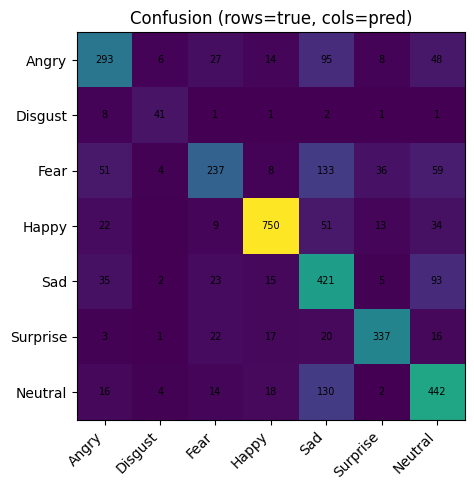

   Angry: 59.67%
 Disgust: 74.55%
    Fear: 44.89%
   Happy: 85.32%
     Sad: 70.88%
Surprise: 81.01%
 Neutral: 70.61%


In [76]:
# === Cell 19: Confusion matrix + per-class accuracy (test) ===
import itertools
IDX2EMO = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}

@torch.no_grad()
def confusion_matrix_and_report(model, loader, num_classes=7, use_ema=True):
    ema_local = globals().get("ema_obj", None)
    if use_ema and ema_local is not None: ema_local.apply_shadow(model)
    model.eval(); cm=torch.zeros(num_classes,num_classes,dtype=torch.int64)
    for xb, yb in loader:
        xb, yb = xb.to(model.device), yb.to(model.device)
        xb = ((xb/255.) - 0.5) * 2.0
        preds = model(xb).argmax(1)
        for t,p in zip(yb.view(-1), preds.view(-1)):
            cm[t.long(), p.long()] += 1
    if use_ema and ema_local is not None: ema_local.restore(model)
    denom = cm.sum(1).clamp(min=1).cpu().numpy()
    per_class = (cm.diag().cpu().numpy() / denom) * 100.0
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,5)); plt.imshow(cm.cpu()); plt.title("Confusion (rows=true, cols=pred)")
    plt.xticks(range(7), [IDX2EMO[i] for i in range(7)], rotation=45, ha='right')
    plt.yticks(range(7), [IDX2EMO[i] for i in range(7)])
    for i,j in itertools.product(range(7), range(7)):
        if cm[i,j]>0: plt.text(j,i,int(cm[i,j]),ha='center',va='center',fontsize=7)
    plt.tight_layout(); plt.show()
    for i,a in enumerate(per_class):
        print(f"{IDX2EMO[i]:>8s}: {a:.2f}%")

confusion_matrix_and_report(model, test_dl, use_ema=True)


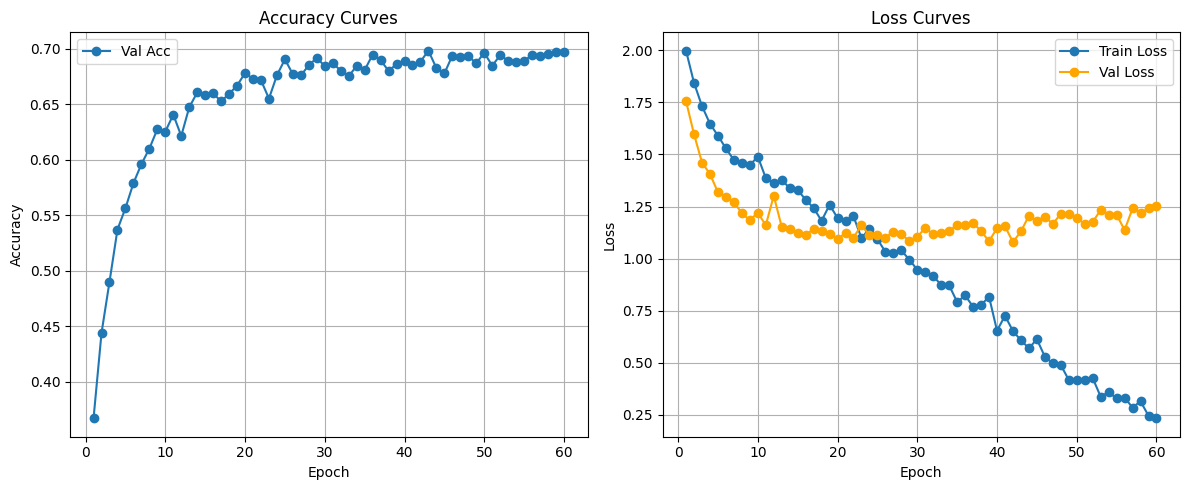

In [77]:
# === Cell: Plot Accuracy and Loss Curves ===
import matplotlib.pyplot as plt

# Example structure of history:
# history = [
#   {'epoch': 1, 'train_loss': 1.45, 'val_loss': 1.22, 'train_acc': 0.46, 'val_acc': 0.48, 'test_acc': 0.47},
#   {'epoch': 2, 'train_loss': 1.38, 'val_loss': 1.18, 'train_acc': 0.51, 'val_acc': 0.53, 'test_acc': 0.52},
#   ...
# ]

epochs     = [m['epoch']      for m in history]
train_loss = [m.get('train_loss') for m in history]
val_loss   = [m.get('val_loss')   for m in history]
train_acc  = [m.get('train_acc')  for m in history]
val_acc    = [m.get('val_acc')    for m in history]

# If you logged test_acc per epoch
test_acc   = [m.get('test_acc') for m in history] if 'test_acc' in history[0] else None

plt.figure(figsize=(12,5))

# 1. Accuracy plot
plt.subplot(1,2,1)
if train_acc[0] is not None:
    plt.plot(epochs, train_acc, label="Train Acc", marker='o')
plt.plot(epochs, val_acc, label="Val Acc", marker='o')
if test_acc is not None and any(v is not None for v in test_acc):
    plt.plot(epochs, test_acc, label="Test Acc", marker='x')
elif 'test_post' in globals():
    plt.axhline(test_post, color='red', linestyle='--', label=f"Final Test Acc = {test_post:.4f}")
plt.title("Accuracy Curves")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.legend(); plt.grid(True)

# 2. Loss plot
plt.subplot(1,2,2)
if train_loss[0] is not None:
    plt.plot(epochs, train_loss, label="Train Loss", marker='o')
plt.plot(epochs, val_loss, label="Val Loss", marker='o', color='orange')
plt.title("Loss Curves")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.show()


# === Cell 20: FLOPs (fvcore) + Accuracy/GFLOP ===

In [78]:
%pip install fvcore


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=bb9092ac7d1afcc5d585fcfdd765ed850af645555b0e2d543d105ebeba59cf26
  Stored in directory: /root/.cache/pip/wheels/ed/9f/a5/e4f5b27454ccd4596bd8b62432c7d6b1ca9fa22aef9d70a16a
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31527 sha256=ff0959677ddf9c29a8b6e6f1b7f3ba1d1ce87bda16cb739581ce5c54956d6d33
  Stored in directory: /root/.cache/pip/wheels/7c/96/04/4f5f31ff812f684f69f40cb1634357812220aac58d4698048c
Successfully built fvcore iopath


In [79]:
# === Cell 21: FLOPs (fvcore) + Accuracy/GFLOP ===
import importlib, subprocess
try:
    from fvcore.nn import FlopCountAnalysis
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "fvcore"])
    from fvcore.nn import FlopCountAnalysis

model.eval()
# FLOPs don't depend on value scale; this shape matches the model's 1-channel input.
dummy = torch.randn(1, 1, CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"], device=model.device)
total_flops = FlopCountAnalysis(model, (dummy,)).total()
MFLOPs = total_flops / 1e6
GFLOPs = total_flops / 1e9
print(f"[FLOPs] {GFLOPs:.4f} GFLOPs per forward")

def best_acc(*vals):
    vals=[v for v in vals if isinstance(v,(float,int))]
    return max(vals) if vals else None

acc_best_val  = best_acc(val_acc_base, val_acc_ema)
acc_best_test = best_acc(test_acc_base, test_acc_ema, test_acc_tta)

def efficiency_pct_per_gflop(acc_frac, gflops): return (acc_frac*100.0)/gflops

if acc_best_test is not None and GFLOPs>0:
    print(f"[Efficiency] Test Accuracy/GFLOP: {efficiency_pct_per_gflop(acc_best_test, GFLOPs):.2f} (% per GFLOP)")


features.1.0.stochastic_depth, features.2.0.stochastic_depth, features.2.1.stochastic_depth, features.3.0.stochastic_depth, features.3.1.stochastic_depth, features.4.0.stochastic_depth, features.4.1.stochastic_depth, features.4.2.stochastic_depth, features.5.0.stochastic_depth, features.5.1.stochastic_depth, features.5.2.stochastic_depth, features.6.0.stochastic_depth, features.6.1.stochastic_depth, features.6.2.stochastic_depth, features.6.3.stochastic_depth, features.7.0.stochastic_depth


[FLOPs] 0.0747 GFLOPs per forward
[Efficiency] Test Accuracy/GFLOP: 940.95 (% per GFLOP)


In [80]:
# =========================
# TESTING: accuracy + image predictions
# =========================
import torch, numpy as np
from PIL import Image
import torchvision.transforms.functional as VF

# --- Class names for readability ---
CLASS_NAMES = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# --- Normalisation used for eval ---
def _to_m11(x: torch.Tensor) -> torch.Tensor:
    # x in [0,255] (uint8/float) -> float in [-1,1]
    return ((x.float() / 255.0) - 0.5) * 2.0

# --- 1) Load the trained checkpoint ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt_path = str(CONFIG.get("SAVE_BEST_PATH", ""))  # e.g., "project/checkpoints/best_fer.pth"
assert ckpt_path, "CONFIG['SAVE_BEST_PATH'] is empty; set the checkpoint path first."

# Rebuild model skeleton exactly as trained
model = HybridEffNet(num_classes=7, classifier_dropout=0.30, use_cbam=True).to(device)
ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model_state"], strict=True)
model.eval()

# --- 2) Compute and print test accuracy (PrivateTest) ---
@torch.no_grad()
def eval_accuracy(model, loader) -> float:
    model.eval()
    correct, total = 0, 0
    for xb, yb in loader:
        xb = _to_m11(xb.to(device, non_blocking=True))
        yb = yb.to(device, non_blocking=True)
        logits = model(xb)
        pred = logits.argmax(1)
        correct += (pred == yb).sum().item()
        total   += yb.numel()
    return correct / max(1, total)

test_acc = eval_accuracy(model, test_dl)
print(f"[Test] accuracy (PrivateTest) = {test_acc:.4f}")

# --- 3a) Predict a few samples from the FER2013 test loader ---
@torch.no_grad()
def preview_test_predictions(model, loader, n=12):
    model.eval()
    xb, yb = next(iter(loader))                 # one batch
    xb = xb[:n]                                 # first n images
    gt = yb[:n].cpu().numpy()
    xb_dev = _to_m11(xb.to(device, non_blocking=True))
    logits = model(xb_dev)
    probs  = logits.softmax(1).cpu().numpy()
    pred   = probs.argmax(1)
    # print a small table
    print("\n[Index]  Pred (pmax)     |  GT")
    for i in range(n):
        pclass = int(pred[i]); gclass = int(gt[i])
        pmax   = float(probs[i, pclass])
        print(f"{i:>6d}  {CLASS_NAMES[pclass]:<12s} ({pmax:0.3f}) |  {CLASS_NAMES[gclass]}")
    return pred, gt

_ = preview_test_predictions(model, test_dl, n=12)

# --- 3b) Predict arbitrary external images (file paths) ---
@torch.no_grad()
def predict_images(model, image_paths):
    """
    image_paths: List[str] to arbitrary images.
    Preprocessing: grayscale -> resize to 96x96 -> tensor [1,H,W] -> [-1,1].
    """
    model.eval()
    batch = []
    for path in image_paths:
        img = Image.open(path).convert("L")            # force grayscale
        img = img.resize((CONFIG["IMG_SIZE"], CONFIG["IMG_SIZE"]), Image.BILINEAR)
        x = torch.from_numpy(np.array(img, dtype=np.uint8))[None, ...]  # [1,H,W] uint8
        batch.append(x)
    xb = torch.stack(batch, dim=0)                     # [B,1,H,W]
    xb = _to_m11(xb).to(device, non_blocking=True)
    logits = model(xb)
    probs  = logits.softmax(1).cpu().numpy()
    preds  = probs.argmax(1)
    # pretty-print
    print("\n[External Image Predictions]")
    for path, p in zip(image_paths, preds):
        print(f"{path}  ->  {CLASS_NAMES[int(p)]} (p={probs[list(preds).index(p), int(p)]:.3f})")
    return preds, probs

# Example usage for external files (uncomment and set your paths):
# preds, probs = predict_images(model, [
#     "/content/some_face1.png",
#     "/content/some_face2.jpg",
# ])


[Test] accuracy (PrivateTest) = 0.7030

[Index]  Pred (pmax)     |  GT
     0  Angry        (0.330) |  Angry
     1  Sad          (0.758) |  Surprise
     2  Fear         (0.580) |  Neutral
     3  Angry        (0.563) |  Sad
     4  Surprise     (0.679) |  Fear
     5  Angry        (0.878) |  Angry
     6  Neutral      (0.521) |  Sad
     7  Happy        (0.827) |  Happy
     8  Fear         (0.887) |  Angry
     9  Happy        (0.771) |  Happy
    10  Happy        (0.507) |  Surprise
    11  Happy        (0.863) |  Happy


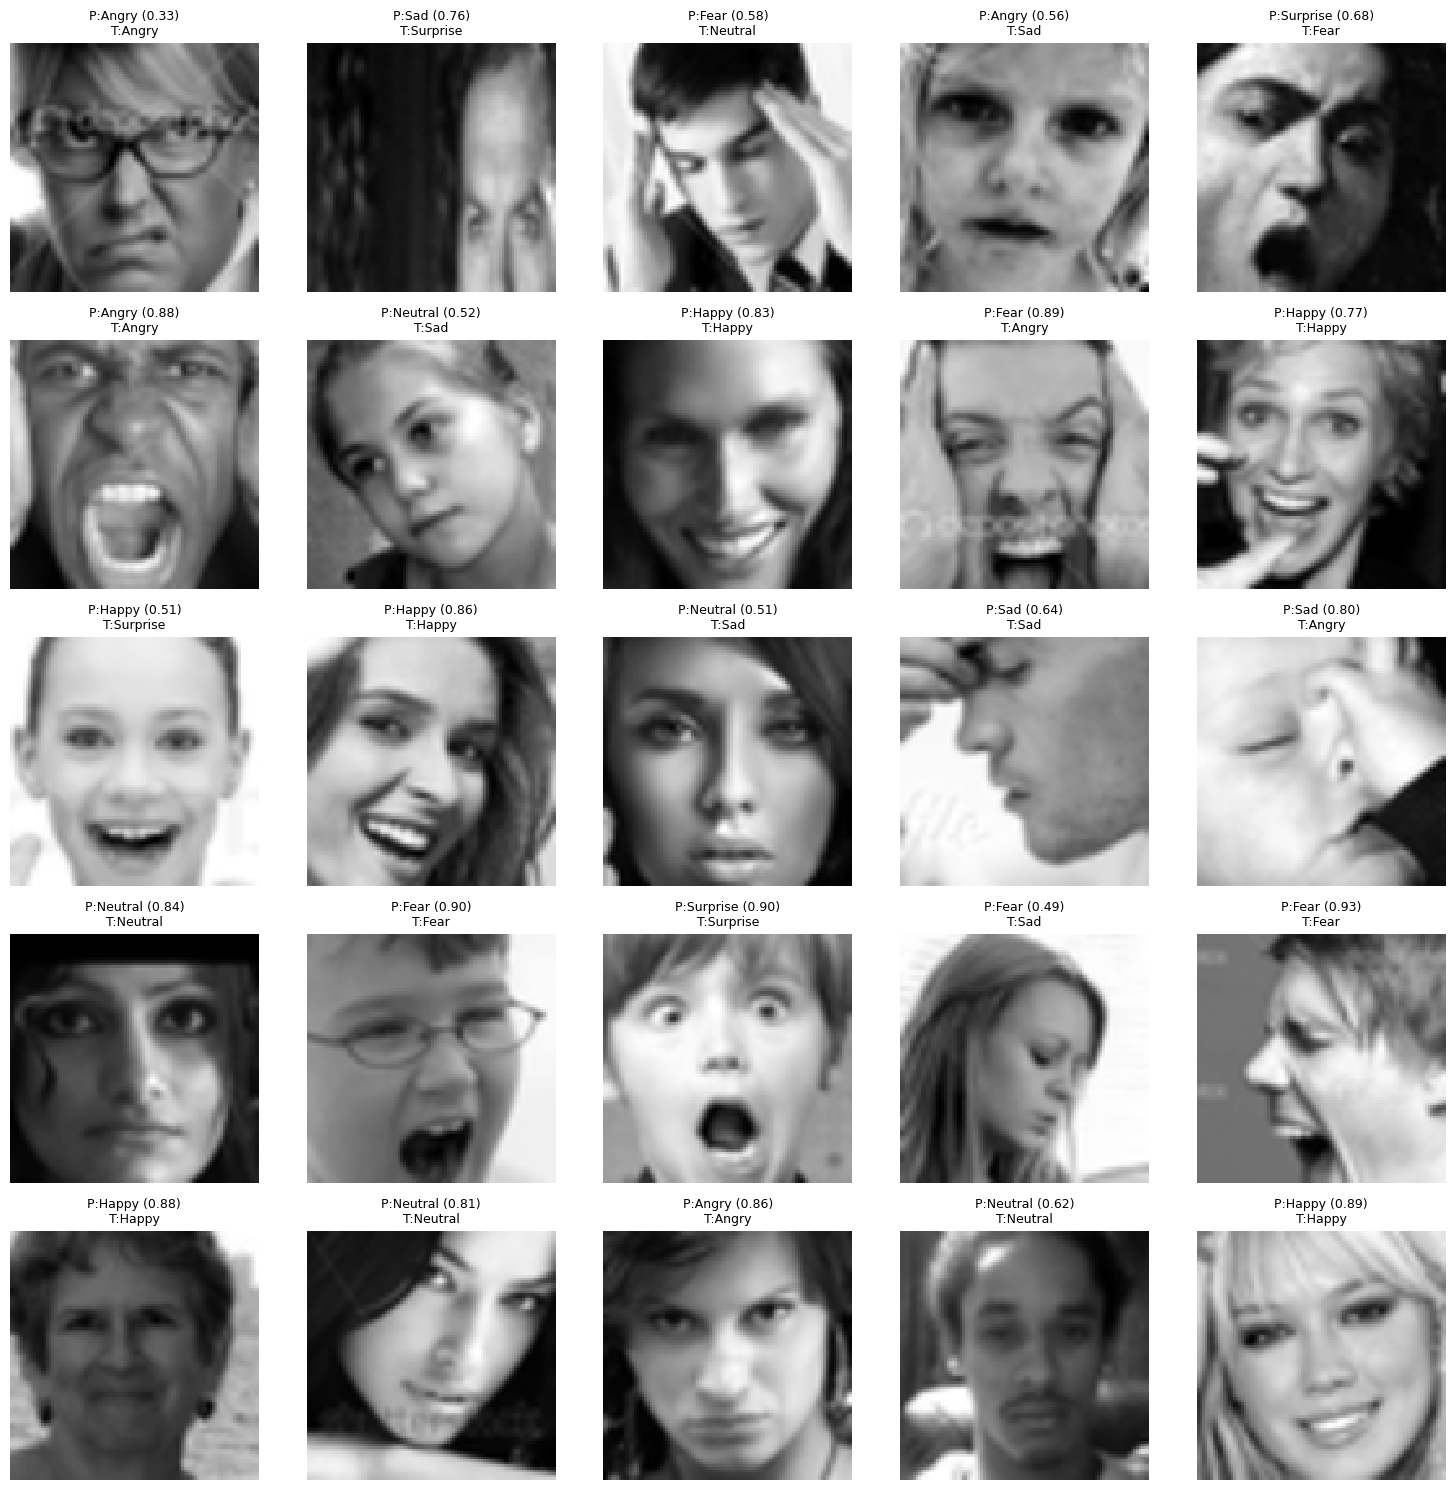

In [81]:
# === Cell B: Visualize predictions on Test images (robust / auto-range) ===
import torch, numpy as np, matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Class names (adjust if your label order differs)
Labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise','Neutral']

# If you used my BN-recal cell, EVAL_TF may exist. Otherwise this stays None.
EVAL_TF = globals().get('EVAL_TF', None)

def _transform_includes_normalize(transform) -> bool:
    """Detects torchvision.transforms.Normalize inside a Compose-like transform."""
    try:
        from torchvision.transforms import Normalize
        seq = getattr(transform, 'transforms', None)
        return any(isinstance(t, Normalize) for t in (seq or []))
    except Exception:
        return False

@torch.no_grad()
def _model_ready_batch(xb: torch.Tensor, dev: torch.device) -> torch.Tensor:
    """
    Returns a tensor ready for the model:
    - If val/test transform already contains Normalize(0.5,0.5), pass through.
    - Otherwise apply explicit ((x/255)-0.5)*2 normalization.
    """
    xb = xb.to(dev, non_blocking=True)
    need_explicit_norm = True
    if EVAL_TF is not None and _transform_includes_normalize(EVAL_TF):
        need_explicit_norm = False
    if need_explicit_norm:
        xb = ((xb / 255.0) - 0.5) * 2.0
    return xb

def _to_display(img: torch.Tensor) -> np.ndarray:
    """
    Convert a single image tensor to HxW in [0,1] for imshow.
    Works for uint8 [0,255], float [0,1], or float [-1,1].
    """
    x = img.detach().cpu()
    if x.ndim == 3 and x.size(0) == 1:  # [1,H,W] -> [H,W]
        x = x[0]
    x = x.float()
    m, M = float(x.min()), float(x.max())
    if M > 1.5:          # likely uint8 [0,255]
        x = x / 255.0
    elif m < -0.25:      # likely [-1,1]
        x = (x * 0.5) + 0.5
    x = x.clamp(0, 1)
    return x.numpy()

@torch.no_grad()
def fetch_batch_and_predict(model, loader: DataLoader):
    """Fetch first batch from loader, run model, return (xb_raw, yb, pred, conf)."""
    model.eval()
    dev = next(model.parameters()).device
    xb, yb = next(iter(loader))
    xb_for_model = _model_ready_batch(xb.clone(), dev)
    logits = model(xb_for_model)
    probs = torch.softmax(logits, dim=1)
    pred  = probs.argmax(1)
    conf  = probs.max(1).values
    return xb, yb, pred.cpu(), conf.cpu()

# If you want EMA weights evaluated, uncomment:
# try: ema_tail.apply_shadow(model)
# except NameError: pass

xb, yb, pred, conf = fetch_batch_and_predict(model, test_dl)

# --- Grid render ---
K = min(25, xb.size(0))   # number of images to show
cols = 5
rows = int(np.ceil(K / cols))
plt.figure(figsize=(cols * 3, rows * 3))

for i in range(K):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(_to_display(xb[i]), cmap='gray', interpolation='nearest')
    t = Labels[int(yb[i])]
    p = Labels[int(pred[i])]
    c = float(conf[i])
    ax.set_title(f"P:{p} ({c:.2f})\nT:{t}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

# If you applied EMA above and want to revert to base weights, uncomment:
# try: ema_tail.restore(model)
# except NameError: pass


# === Cell 22: Save final checkpoint & reload sanity ===


In [82]:
# === Cell 22: Save final checkpoint & reload sanity ===
FINAL_PATH = CKPT_DIR / "final_fer_model.pth"
torch.save({"model_state": model.state_dict()}, FINAL_PATH)
print(f"[Save] {FINAL_PATH}")

ckpt = torch.load(FINAL_PATH, map_location="cpu")
model.load_state_dict(ckpt["model_state"]); model.to(model.device).eval()
with torch.no_grad():
    xb, yb = next(iter(val_dl))
    xb = ((xb/255.) - 0.5) * 2.0
    out = model(xb.to(model.device))
print("[Reload] Sanity forward OK:", tuple(out.shape))


[Save] project/checkpoints/final_fer_model.pth
[Reload] Sanity forward OK: (384, 7)
